In [1]:
#%reset # clears variables in workspace

# import libraries
# Pyomo stuff
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

# other
import sympy as sym
import numpy as np

from IPython.display import display #for pretty printing

import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
%matplotlib inline

# create the model
m = ConcreteModel()

In [2]:
N = 20 # how many points are in the trajectory
hm = 1 #0.5/N #scaling factor
m.N = RangeSet(N) # For defining ordered/numerical sets. Works like 'range' in python.

m.g = Param(initialize = 9.81)
# m.X0 = Param(initialize = 0.0) # position of fixed base
# m.Z0 = Param(initialize = 1.0)
# m.h = Param(initialize = 0.02) # time step

# mass of links
m.m1 = Param(initialize = 0.35)
m.m2 = Param(initialize = 0.15)
m.m3 = Param(initialize = 0.35)
m.m4 = Param(initialize = 0.15)

mbody = m.m1.value+m.m2.value+m.m3.value+m.m4.value
mBW = mbody*m.g.value

# length of links
m.l1 = Param(initialize = 0.12) 
m.l2 = Param(initialize = 0.24) 
m.l3 = Param(initialize = 0.12) 
m.l4 = Param(initialize = 0.24) 
# IMPORTANT make sure your values are declared as floats: many a long debugging session has eventually led me to find something
# unexpectedly has a value of zero because of integer devision gone wrong. Goddamn implicit typing fuuuuuuuuuuuuuuuuuuuuuuuuuuu

#Inertia
m.In1= Param(initialize = m.m1.value*m.l1.value**2/12) 
m.In2= Param(initialize = m.m2.value*m.l2.value**2/12)
m.In3= Param(initialize = m.m3.value*m.l3.value**2/12)
m.In4= Param(initialize = m.m4.value*m.l4.value**2/12)

#Forces
m.t_max=6.864655 #Nm, corresponding to a 8V input
m.w_max=8.055366 #rad/s, corresponding to a 8V input

#Not exactly sure what this is?
m.distance=0.8

print("Done")

Done


In [3]:
# create symbolic variables

# system parameters
g = sym.symbols('g')
m1,m2,m3,m4 = sym.symbols(['m1','m2','m3','m4']) # mass of links
l1,l2,l3,l4 = sym.symbols(['l1','l2','l3','l4']) # length of links
In1,In2,In3,In4 = sym.symbols(['In1','In2','In3','In4']) # moment of intertia of links

# generalized coordinates
x,z,th1,th2,th3,th4 = sym.symbols(['x','z','theta1','theta2','theta3','theta4']) #position
dx,dz,dth1,dth2,dth3,dth4 = sym.symbols(['\dot{x}','\dot{z}','\dot{\\theta}_{1}','\dot{\\theta}_{2}','\dot{\\theta}_{3}','\dot{\\theta}_{4}']) #velocity
ddx,ddz,ddth1,ddth2,ddth3,ddth4 = sym.symbols(['\ddot{x}','\ddot{z}','\ddot{\\theta}_{1}','\ddot{\\theta}_{2}','\ddot{\\theta}_{3}','\ddot{\\theta}_{4}']) #acceleration

q = sym.Matrix([[x],[z],[th1],[th2],[th3],[th4]]) #group into matrices
dq = sym.Matrix([[dx],[dz],[dth1],[dth2],[dth3],[dth4]])
ddq = sym.Matrix([[ddx],[ddz],[ddth1],[ddth2],[ddth3],[ddth4]])

# forces
tau1,tau2,tau3,tau4,GRF1x,GRF1z,GRF2x,GRF2z = sym.symbols(['\\tau_1','\\tau_2','\\tau_3','\\tau_4','G1_x','G1_z','G2_x','G2_z']) 

print('Done')

Done


In [4]:
# STEP 1: position vector (COM of each link) 
#using relative angles 

x1 = x + 0.5*l1*sym.sin(th1)
z1 = z - 0.5*l1*sym.cos(th1)

x2 = x + l1*sym.sin(th1) + 0.5*l2*sym.sin(th1+th2)
z2 = z - l1*sym.cos(th1) - 0.5*l2*sym.cos(th1+th2)

x3 = x + 0.5*l3*sym.sin(th3)
z3 = z - 0.5*l3*sym.cos(th3)

x4 = x + l3*sym.sin(th3) + 0.5*l4*sym.sin(th3+th4)
z4 = z - l3*sym.cos(th3) - 0.5*l4*sym.cos(th3+th4)

foot1x = sym.Matrix([x + l1*sym.sin(th1) + l2*sym.sin(th1+th2)])
foot1z = sym.Matrix([z - l1*sym.cos(th1) - l2*sym.cos(th1+th2)]) 
foot1z = foot1z[0].simplify()
foot1_pos= sym.Matrix([[foot1x],[foot1z]]);

foot2x = sym.Matrix([x + l3*sym.sin(th3) + l4*sym.sin(th3+th4)])
foot2z = sym.Matrix([z - l3*sym.cos(th3) - l4*sym.cos(th3+th4)]) 
foot2z = foot2z[0].simplify()
foot2_pos= sym.Matrix([[foot2x],[foot2z]]);

print('Done')

Done


In [5]:
# STEP 2: generate expressions for the system space velocities
p1 = sym.Matrix([x1,z1])
v1 = p1.jacobian(q)*dq
[dx1,dz1] = v1

p2 = sym.Matrix([x2,z2])
v2 = p2.jacobian(q)*dq
[dx2,dz2] = v2 

p3 = sym.Matrix([x3,z3])
v3 = p3.jacobian(q)*dq
[dx3,dz3] = v3 

p4 = sym.Matrix([x4,z4])
v4 = p4.jacobian(q)*dq
[dx4,dz4] = v3 

foot1dx = foot1x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot1dx = foot1dx[0].simplify()

foot2dx = foot2x.jacobian(q)*dq #This is symbolic again, so it doesnt change with the collocation
foot2dx = foot2dx[0].simplify()

print('Done')

Done


In [6]:
# STEP 3: generate expressions for the kinetic and potential energy

#Stacy Shield's method
# T = sym.Matrix([0.5*m1*(dx1**2+dy1**2) + 0.5*m2*(dx2**2+dy2**2) + 0.5*In1*dth1a**2 + 0.5*In2*dth2a**2])
# V = sym.Matrix([m1*g*y1 + m2*g*y2])

#Callen Fisher's method, better for bigger problems.
M1 = sym.Matrix([[m1,m1]])
M2 = sym.Matrix([[m2,m2]])
M3 = sym.Matrix([[m3,m3]])
M4 = sym.Matrix([[m4,m4]])

I1=sym.Matrix([[In1]])
I2=sym.Matrix([[In2]])
I3=sym.Matrix([[In3]])
I4=sym.Matrix([[In4]])

W1=sym.Matrix([[dth1]])
W2=sym.Matrix([[dth1+dth2]])
W3=sym.Matrix([[dth3]])
W4=sym.Matrix([[dth3+dth4]])

# linear kinetic energy:
Tl = 0.5*M1*sym.matrix_multiply_elementwise(v1,v1) + 0.5*M2*sym.matrix_multiply_elementwise(v2,v2) + 0.5*M3*sym.matrix_multiply_elementwise(v3,v3) + 0.5*M4*sym.matrix_multiply_elementwise(v4,v4)
# angular kinetic energy:
Tw =  0.5*I1*sym.matrix_multiply_elementwise(W1,W1) + 0.5*I2*sym.matrix_multiply_elementwise(W2,W2) + 0.5*I3*sym.matrix_multiply_elementwise(W3,W3) + 0.5*I4*sym.matrix_multiply_elementwise(W4,W4)
#this should be a 3*3 matrix of MOI and a vector of angular vel... w'*MOI*w

T = sym.Matrix([Tl[0]])+sym.Matrix([Tw[0]])
# potential energy
V = m1*g*p1[1] + m2*g*p2[1] + m3*g*p3[1] + m4*g*p4[1]
print('Done')

Done


In [7]:
#Use the manipulator equation to calculate the EoM
#EOM=Mddq+Cdq+G-Q-J.'*GRF ---> Callen's method

M=T.jacobian(dq)
M=M.transpose()
M=M.jacobian(dq)              

C  = sym.zeros(len(q),len(q))                                                         
for i in range(len(q)):                                             
    for j in range(len(q)):
        for n in range(len(q)):
            C[i,j] = C[i,j]+ 0.5*(sym.diff(M[i,j],q[n]) + sym.diff(M[i,n],q[j]) - sym.diff(M[j,n],q[i]))*dq[n];

G  = sym.zeros(len(q),1)                                         
for i in range(len(q)):
    G[i] = sym.diff(V,q[i]);       

Q = sym.zeros(len(q),1)
Q[0]=0                 #x
Q[1]=0                 #z
Q[2]=tau1              #th1
Q[3]=tau2              #th2
Q[4]=tau3              #th3
Q[5]=tau4              #th4


J1=foot1_pos.jacobian(q)
GRF_1 = J1.transpose()*sym.Matrix([[GRF1x],[GRF1z]]) 

J2=foot2_pos.jacobian(q)
GRF_2 = J2.transpose()*sym.Matrix([[GRF2x],[GRF2z]])

EOM=M*ddq+C*dq+G-Q-GRF_1-GRF_2

EOMs = sym.zeros(len(q),1)
for j in range(len(q)):
    EOMs[j] = EOM[j].simplify()  #--> Helps to make simulation faster for bigger problems

#display(EOMs[0])
print('Done')

Done


In [8]:
# Lambdify

func_map = {'sin':sin, 'cos':cos} 

sym_list = [g,m1,m2,m3,m4,l1,l2,l3,l4,
            In1,In2,In3,In4,x,z,th1,th2,th3,th4,
            dx,dz,dth1,dth2,dth3,dth4,ddx,ddz,ddth1,ddth2,
            ddth3,ddth4,tau1,tau2,tau3,tau4,GRF1x,GRF1z,GRF2x,GRF2z]
            
lambEOM_x = sym.lambdify(sym_list,EOMs[0],modules = [func_map])
lambEOM_y = sym.lambdify(sym_list,EOMs[1],modules = [func_map])
lambEOM_th1 = sym.lambdify(sym_list,EOMs[2],modules = [func_map])
lambEOM_th2 = sym.lambdify(sym_list,EOMs[3],modules = [func_map])
lambEOM_th3 = sym.lambdify(sym_list,EOMs[4],modules = [func_map])
lambEOM_th4 = sym.lambdify(sym_list,EOMs[5],modules = [func_map])

lamb_foot1z = sym.lambdify(sym_list,foot1z,modules = [func_map])
lamb_foot1dx = sym.lambdify(sym_list,foot1dx,modules = [func_map])

lamb_foot2z = sym.lambdify(sym_list,foot2z,modules = [func_map])
lamb_foot2dx = sym.lambdify(sym_list,foot2dx,modules = [func_map])

print('Done')

Done


In [9]:
# Variables
cN = 3
m.cN =RangeSet(cN)

links = [('leg',1),('leg',2),('leg',3),('leg',4)]
m.L = Set(dimen=2, initialize=links)

DOFs = ['x','z','theta_1','theta_2','theta_3','theta_4'] # generalized coordinates
m.DOF = Set(initialize = DOFs) 

# system coordinates
#collocation points
m.q = Var(m.N, m.cN, m.DOF) # position
m.dq = Var(m.N, m.cN, m.DOF) # velocity
m.ddq = Var(m.N, m.cN, m.DOF) # acceleration

#nodes
m.q0 = Var(m.N, m.DOF) # position
m.dq0 = Var(m.N, m.DOF) # velocity

#time
m.tt = Var(m.N, m.cN)
m.tt0 = Var(m.N)

m.h = Var(m.N, bounds =(0.1,2.0))

a = [[0.19681547722366, 0.39442431473909, 0.37640306270047],
     [-0.06553542585020, 0.29207341166523, 0.51248582618842],
     [0.02377097434822, -0.04154875212600, 0.11111111111111]]
print('Done')

Done


In [10]:
def ContConstraint_p (m, n, dof):
    if n > 1:
        return m.q0[n,dof] == m.q[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_p = Constraint(m.N, m.DOF, rule = ContConstraint_p)

def ContConstraint_v (m, n, dof):
    if n > 1:
        return m.dq0[n,dof] == m.dq[n-1,3,dof]
    else:
        return Constraint.Skip
m.ContConstraint_v = Constraint(m.N, m.DOF, rule = ContConstraint_v)

def ContConstraint_tt (m, n):
    if n > 1:
        return m.tt0[n] == m.tt[n-1,3]
    else:
        return Constraint.Skip
m.ContConstraint_tt = Constraint(m.N, rule = ContConstraint_tt)

print('Done')

Done


In [11]:
def integrate_p(m, n, c, dof): # for positions
    if n > 0:
        return m.q[n,c,dof] == m.q0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.dq[n,1,dof] \
                                                         +a[1][c-1]*m.dq[n,2,dof] \
                                                         +a[2][c-1]*m.dq[n,3,dof])
    else:
        return Constraint.Skip #use this to leave out members of a set that the constraint doesn't apply to
m.integrate_p = Constraint(m.N, m.cN, m.DOF, rule = integrate_p)

def integrate_v(m,n,c,dof): # for velocities
    if n > 0:
        return m.dq[n,c,dof] == m.dq0[n, dof] + hm*m.h[n]*(a[0][c-1]*m.ddq[n,1,dof] \
                                                           +a[1][c-1]*m.ddq[n,2,dof] \
                                                           +a[2][c-1]*m.ddq[n,3,dof])
    else:
        return Constraint.Skip 
m.integrate_v = Constraint(m.N, m.cN, m.DOF, rule = integrate_v)

def integrate_tt(m,n,c): # for time 
    if n > 0:
        return m.tt[n,c] == m.tt0[n] + hm*m.h[n]*(a[0][c-1]+a[1][c-1]+a[2][c-1])
    else:
        return Constraint.Skip 
m.integrate_tt = Constraint(m.N, m.cN, rule = integrate_tt)

print('Done')

Done


In [12]:
signs = ['ps', 'ng']
m.sgn = Set(initialize = ['ps', 'ng'])
WDOFs = ['X','Z','THETA1', 'THETA2','THETA3','THETA4']
m.WDOF = Set(initialize=WDOFs) #change the coordinates
m.GRF1 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,None)) # should bound it to 10*m_robot*g
m.GRF2 = Var(m.N, m.cN, m.WDOF, m.sgn, bounds = (0.0,None)) # should bound it to 10*m_robot*g
m.eps = Param(initialize=1000.0, mutable=True)
m.mu = Param(initialize =0.60)
print('Done')

Done


In [13]:
# SLACK VARIABLES
m.a_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_1  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_1 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_1   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_1      = Var(m.N, m.cN, bounds = (0.0,None)) 

m.a_contact_2  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_contact_2  = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_friction_2 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_friction_2 = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_p_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_p_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.a_slip_n_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.b_slip_n_2   = Var(m.N, m.cN, bounds = (0.0,None)) 
m.gamma_2      = Var(m.N, m.cN, bounds = (0.0,None)) 
print('Done')

Done


In [14]:
# CONTACT
def def_a_contact_1(m,n,c):   
        var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
        return m.a_contact_1[n,c] == lamb_foot1z(*var_list)
m.def_a_contact_1 = Constraint(m.N, m.cN, rule = def_a_contact_1)
def def_b_contact_1(m,n,c):   
    return m.b_contact_1[n,c] == m.GRF1[n,c,'Z','ps']
m.def_b_contact_1 = Constraint(m.N, m.cN, rule = def_b_contact_1)

def def_a_contact_2(m,n,c):   
        var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
        return m.a_contact_2[n,c] == lamb_foot2z(*var_list)
m.def_a_contact_2 = Constraint(m.N, m.cN, rule = def_a_contact_2)
def def_b_contact_2(m,n,c):   
    return m.b_contact_2[n,c] == m.GRF2[n,c,'Z','ps']
m.def_b_contact_2 = Constraint(m.N, m.cN, rule = def_b_contact_2)

print('Done')

Done


In [15]:
# FRICTION CONE
def def_a_friction_1(m,n,c):   
    return m.a_friction_1[n,c] == m.mu*m.GRF1[n,c,'Z','ps'] - (m.GRF1[n,c,'X','ps'] + m.GRF1[n,c,'X','ng'])
m.def_a_friction_1 = Constraint(m.N, m.cN, rule = def_a_friction_1)
def def_b_friction_1(m,n,c):   
    return m.b_friction_1[n,c] == m.gamma_1[n,c]
m.def_b_friction_1 = Constraint(m.N, m.cN, rule = def_b_friction_1)

def def_a_friction_2(m,n,c):   
    return m.a_friction_2[n,c] == m.mu*m.GRF2[n,c,'Z','ps'] - (m.GRF2[n,c,'X','ps'] + m.GRF2[n,c,'X','ng'])
m.def_a_friction_2 = Constraint(m.N, m.cN, rule = def_a_friction_2)
def def_b_friction_2(m,n,c):   
    return m.b_friction_2[n,c] == m.gamma_2[n,c]
m.def_b_friction_2 = Constraint(m.N, m.cN, rule = def_b_friction_2)

print('Done')

Done


In [16]:
#SLIP POS DIR
def def_a_slip_p_1(m,n,c):   
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
    return m.a_slip_p_1[n,c] ==m.gamma_1[n,c]+lamb_foot1dx(*var_list)
m.def_a_slip_p_1 = Constraint(m.N, m.cN, rule = def_a_slip_p_1)
def def_b_slip_p_1(m,n,c):   
    return m.b_slip_p_1[n,c] == m.GRF1[n,c,'X','ps']
m.def_b_slip_p_1 = Constraint(m.N, m.cN, rule = def_b_slip_p_1)

# SLIP NEG DIR
def def_a_slip_n_1(m,n,c):   
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
    return m.a_slip_n_1[n,c] ==m.gamma_1[n,c]-lamb_foot1dx(*var_list)
m.def_a_slip_n_1 = Constraint(m.N, m.cN, rule = def_a_slip_n_1)
def def_b_slip_n_1(m,n,c):   
    return m.b_slip_n_1[n,c] == m.GRF1[n,c,'X','ng']
m.def_b_slip_n_1 = Constraint(m.N, m.cN, rule = def_b_slip_n_1)

#SLIP POS DIR
def def_a_slip_p_2(m,n,c):   
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
    return m.a_slip_p_2[n,c] ==m.gamma_2[n,c]+lamb_foot2dx(*var_list)
m.def_a_slip_p_2 = Constraint(m.N, m.cN, rule = def_a_slip_p_2)
def def_b_slip_p_2(m,n,c):   
    return m.b_slip_p_2[n,c] == m.GRF2[n,c,'X','ps']
m.def_b_slip_p_2 = Constraint(m.N, m.cN, rule = def_b_slip_p_2)

# SLIP NEG DIR
def def_a_slip_n_2(m,n,c):   
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            0,0,0,0,0,0,0,0]
    return m.a_slip_n_2[n,c] ==m.gamma_2[n,c]-lamb_foot2dx(*var_list)
m.def_a_slip_n_2 = Constraint(m.N, m.cN, rule = def_a_slip_n_2)
def def_b_slip_n_2(m,n,c):   
    return m.b_slip_n_2[n,c] == m.GRF2[n,c,'X','ng']
m.def_b_slip_n_2 = Constraint(m.N, m.cN, rule = def_b_slip_n_2)

print('Done')

Done


In [17]:
#Leg 1
def def_contact_1_pr(m,n):
    a_contact_1_pr = m.a_contact_1[n,1] + m.a_contact_1[n,2] + m.a_contact_1[n,3] 
    b_contact_1_pr = m.b_contact_1[n,1] + m.b_contact_1[n,2] + m.b_contact_1[n,3]  
    return a_contact_1_pr*b_contact_1_pr <= m.eps
m.def_contact_1_pr = Constraint(m.N, rule = def_contact_1_pr)

def def_friction_1_pr(m,n):
    a_friction_1_pr = m.a_friction_1[n,1] + m.a_friction_1[n,2] + m.a_friction_1[n,3] 
    b_friction_1_pr = m.b_friction_1[n,1] + m.b_friction_1[n,2] + m.b_friction_1[n,3]  
    return a_friction_1_pr*b_friction_1_pr <= m.eps
m.def_friction_1_pr = Constraint(m.N, rule = def_friction_1_pr)

def def_slip_p_1_pr(m,n):
    a_slip_p_1_pr = m.a_slip_p_1[n,1] + m.a_slip_p_1[n,2] + m.a_slip_p_1[n,3] 
    b_slip_p_1_pr = m.b_slip_p_1[n,1] + m.b_slip_p_1[n,2] + m.b_slip_p_1[n,3]  
    return a_slip_p_1_pr*b_slip_p_1_pr <= m.eps
m.def_slip_p_1_pr = Constraint(m.N, rule = def_slip_p_1_pr)

def def_slip_n_1_pr(m,n):
    a_slip_n_1_pr = m.a_slip_n_1[n,1] + m.a_slip_n_1[n,2] + m.a_slip_n_1[n,3] 
    b_slip_n_1_pr = m.b_slip_n_1[n,1] + m.b_slip_n_1[n,2] + m.b_slip_n_1[n,3]  
    return a_slip_n_1_pr*b_slip_n_1_pr <= m.eps
m.def_slip_n_1_pr = Constraint(m.N, rule = def_slip_n_1_pr)

#Leg 2
def def_contact_2_pr(m,n):
    a_contact_2_pr = m.a_contact_2[n,1] + m.a_contact_2[n,2] + m.a_contact_2[n,3] 
    b_contact_2_pr = m.b_contact_2[n,1] + m.b_contact_2[n,2] + m.b_contact_2[n,3]  
    return a_contact_2_pr*b_contact_2_pr <= m.eps
m.def_contact_2_pr = Constraint(m.N, rule = def_contact_2_pr)

def def_friction_2_pr(m,n):
    a_friction_2_pr = m.a_friction_2[n,1] + m.a_friction_2[n,2] + m.a_friction_2[n,3] 
    b_friction_2_pr = m.b_friction_2[n,1] + m.b_friction_2[n,2] + m.b_friction_2[n,3]  
    return a_friction_2_pr*b_friction_2_pr <= m.eps
m.def_friction_2_pr = Constraint(m.N, rule = def_friction_2_pr)

def def_slip_p_2_pr(m,n):
    a_slip_p_2_pr = m.a_slip_p_2[n,1] + m.a_slip_p_2[n,2] + m.a_slip_p_2[n,3] 
    b_slip_p_2_pr = m.b_slip_p_2[n,1] + m.b_slip_p_2[n,2] + m.b_slip_p_2[n,3]  
    return a_slip_p_2_pr*b_slip_p_2_pr <= m.eps
m.def_slip_p_2_pr = Constraint(m.N, rule = def_slip_p_2_pr)

def def_slip_n_2_pr(m,n):
    a_slip_n_2_pr = m.a_slip_n_2[n,1] + m.a_slip_n_2[n,2] + m.a_slip_n_2[n,3] 
    b_slip_n_2_pr = m.b_slip_n_2[n,1] + m.b_slip_n_1[n,2] + m.b_slip_n_2[n,3]  
    return a_slip_n_2_pr*b_slip_n_2_pr <= m.eps
m.def_slip_n_2_pr = Constraint(m.N, rule = def_slip_n_2_pr)

print('Done')

Done


In [18]:
m.tau_a = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at hip_1
m.tau_b = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at knee_2
m.tau_c = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at hip_3
m.tau_d = Var(m.N, bounds = (-m.t_max,m.t_max)) # actuator torque at knee_4

def def_hip1_motor_model_p(m,n):
    return  m.tau_a[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_1'])
m.def_hip1_motor_model_p = Constraint(m.N, rule = def_hip1_motor_model_p)
def def_hip1_motor_model_n(m,n):
    return  m.tau_a[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_1'])
m.def_hip1_motor_model_n = Constraint(m.N, rule = def_hip1_motor_model_n)

def def_knee2_motor_model_p(m,n):
    return  m.tau_b[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_2'])
m.def_knee2_motor_model_p = Constraint(m.N, rule = def_knee2_motor_model_p)
def def_knee2_motor_model_n(m,n):
    return  m.tau_b[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_2'])
m.def_knee2_motor_model_n = Constraint(m.N, rule = def_knee2_motor_model_n)

def def_hip3_motor_model_p(m,n):
    return  m.tau_c[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_3'])
m.def_hip3_motor_model_p = Constraint(m.N, rule = def_hip3_motor_model_p)
def def_hip3_motor_model_n(m,n):
    return  m.tau_c[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_3'])
m.def_hip3_motor_model_n = Constraint(m.N, rule = def_hip3_motor_model_n)

def def_knee4_motor_model_p(m,n):
    return  m.tau_d[n] <= m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_4'])
m.def_knee4_motor_model_p = Constraint(m.N, rule = def_knee4_motor_model_p)
def def_knee4_motor_model_n(m,n):
    return  m.tau_d[n] >= -m.t_max-m.t_max/m.w_max*(m.dq0[n,'theta_4'])
m.def_knee4_motor_model_n = Constraint(m.N, rule = def_knee4_motor_model_n)

print('Done')

Done


In [19]:
from pyomo.environ import*
from pyomo.opt import SolverFactory
from pyomo.opt import SolverStatus, TerminationCondition

S=1.0 #BW/m.mTot    
#Scaling factor, I avoid scaling the problem, others seem to think it works....

def EOM_x(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_x(*var_list) == 0
m.EOM_x = Constraint(m.N, m.cN, rule = EOM_x)

def EOM_y(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_y(*var_list) == 0
m.EOM_y = Constraint(m.N, m.cN, rule = EOM_y)

def EOM_th1(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_th1(*var_list) == 0
m.EOM_th1 = Constraint(m.N, m.cN, rule = EOM_th1)

def EOM_th2(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_th2(*var_list) == 0
m.EOM_th2 = Constraint(m.N, m.cN, rule = EOM_th2)

def EOM_th3(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_th3(*var_list) == 0
m.EOM_th3= Constraint(m.N, m.cN, rule = EOM_th3)
                      
def EOM_th4(m,n,c):
    tau1_in = S*(m.tau_a[n])
    tau2_in = S*(m.tau_b[n])
    tau3_in = S*(m.tau_c[n])
    tau4_in = S*(m.tau_d[n])
    Gx1_in = S*(m.GRF1[n,c,'X','ps']-m.GRF1[n,c,'X','ng'])
    Gz1_in = S*(m.GRF1[n,c,'Z','ps'])
    Gx2_in = S*(m.GRF2[n,c,'X','ps']-m.GRF2[n,c,'X','ng'])
    Gz2_in = S*(m.GRF2[n,c,'Z','ps'])
    
    var_list = [m.g,m.m1,m.m2,m.m3,m.m4,
            m.l1,m.l2,m.l3,m.l4,m.In1,m.In2,m.In3,m.In4,m.q[n,c,'x'],m.q[n,c,'z'],
            m.q[n,c,'theta_1'],m.q[n,c,'theta_2'],m.q[n,c,'theta_3'],m.q[n,c,'theta_4'],m.dq[n,c,'x'],m.dq[n,c,'z'],
            m.dq[n,c,'theta_1'],m.dq[n,c,'theta_2'],m.dq[n,c,'theta_3'],m.dq[n,c,'theta_4'],m.ddq[n,c,'x'],m.ddq[n,c,'z'],
            m.ddq[n,c,'theta_1'],m.ddq[n,c,'theta_2'],m.ddq[n,c,'theta_3'],m.ddq[n,c,'theta_4'],
            tau1_in,tau2_in,tau3_in,tau4_in,Gx1_in,Gz1_in,Gx2_in,Gz2_in]
    return lambEOM_th4(*var_list) == 0
m.EOM_th4= Constraint(m.N, m.cN, rule = EOM_th4)

print('Done')

Done


In [20]:
def setxBounds(m,n):
    return (-1.0, m.q0[n,'x'], m.distance+1)
m.setxBounds = Constraint(m.N, rule=setxBounds)
def setzBounds(m,n):
    return (0.0, m.q0[n,'z'], 2.0)
m.setzBounds = Constraint(m.N, rule=setzBounds)
def setth1Bounds(m,n):
    return (-2, m.q0[n,'theta_1'], 2)
m.setth1Bounds = Constraint(m.N, rule=setth1Bounds)
def setth2Bounds(m,n):
    return (-2, m.q0[n,'theta_2'], 2)
m.setth2Bounds = Constraint(m.N, rule=setth2Bounds)
def setth3Bounds(m,n):
    return (-2, m.q0[n,'theta_3'], 2)
m.setth3Bounds = Constraint(m.N, rule=setth3Bounds)
def setth4Bounds(m,n):
    return (-2, m.q0[n,'theta_4'], 2)
m.setth4Bounds = Constraint(m.N, rule=setth4Bounds)

def setdxBounds(m,n):
    return (-1, m.dq0[n,'x'],10)
m.setdxBounds = Constraint(m.N, rule=setdxBounds)
def setdzBounds(m,n):
    return (-10, m.dq0[n,'z'],10)
def setdth1Bounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_1'],m.w_max)
m.setdth1Bounds = Constraint(m.N, rule=setdth1Bounds)
def setdth2Bounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_2'],m.w_max)
m.setdth2Bounds = Constraint(m.N, rule=setdth2Bounds)
def setdth3Bounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_3'], m.w_max)
m.setdth3Bounds = Constraint(m.N, rule=setdth3Bounds)
def setdth4Bounds(m,n):
    return (-m.w_max, m.dq0[n,'theta_4'], m.w_max)
m.setdth4Bounds = Constraint(m.N, rule=setdth4Bounds)

print('Done')

Done


In [21]:
R = 1.0
D = 5.0

Domain = np.linspace(0,D,N)
Range = np.linspace(0,R,N)
for n in range(1,N+1):
    for c in range (1, cN+1): 
        #Randomizing Q Matrix
        m.q[n,c,'x'].value = 0.01   
        m.q[n,c,'z'].value  = 0.01
        m.q[n,c,'theta_1'].value = np.random.uniform(-np.pi/2,np.pi/2)   
        m.q[n,c,'theta_2'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_3'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        m.q[n,c,'theta_4'].value  = np.random.uniform(-np.pi/2,np.pi/2)
        
        #Setting everything else to 0.01
        for dof in DOFs:
            m.dq[n,c , dof].value = 0.01
            m.ddq[n,c , dof].value = 0.01
            
        m.GRF1[n,c,'Z','ps'].value = 0.01
        m.GRF1[n,c,'X','ps'].value = 0.01 
        m.GRF1[n,c,'X','ng'].value = 0.01 
        
        m.GRF2[n,c,'Z','ps'].value = 0.01
        m.GRF2[n,c,'X','ps'].value = 0.01 
        m.GRF2[n,c,'X','ng'].value = 0.01 
        
print('Done')

Done


In [22]:
# #DROP TEST
# #--------------------------------------------------------------
# #initial variables
# m.q[1,1,'x'].value = 0.0
# m.q[1,1,'x'].fixed = True
# m.q[1,1,'z'].value = 0.8
# m.q[1,1,'z'].fixed = True
# m.q[1,1,'theta_1'].value = 0.0
# m.q[1,1,'theta_1'].fixed = True
# m.q[1,1,'theta_2'].value = 0.0
# m.q[1,1,'theta_2'].fixed = True
# m.q[1,1,'theta_3'].value = 0.0
# m.q[1,1,'theta_3'].fixed = True
# m.q[1,1,'theta_4'].value = 0.0
# m.q[1,1,'theta_4'].fixed = True

# m.dq[1,1,'x'].value = 0.0
# m.dq[1,1,'x'].fixed = True
# m.dq[1,1,'z'].value = 0.0
# m.dq[1,1,'z'].fixed = True
# m.dq[1,1,'theta_1'].value = 0.0
# m.dq[1,1,'theta_1'].fixed = True
# m.dq[1,1,'theta_2'].value = 0.0
# m.dq[1,1,'theta_2'].fixed = True
# m.dq[1,1,'theta_3'].value = 0.0
# m.dq[1,1,'theta_3'].fixed = True
# m.dq[1,1,'theta_4'].value = 0.0
# m.dq[1,1,'theta_4'].fixed = True

# for dof in DOFs:   
#     for n in range(1,N+1):
#         m.tau_a[n].value = 0
#         m.tau_a[n].fixed = True
#         m.tau_b[n].value = 0
#         m.tau_b[n].fixed = True
#         m.tau_c[n].value = 0
#         m.tau_c[n].fixed = True
#         m.tau_d[n].value = 0
#         m.tau_d[n].fixed = True

In [23]:
#HOP
#---------------------------------------------------------------

# initial condition
m.q[1,1,'x'].value = 0.0
m.q[1,1,'x'].fixed = True
m.q[1,1,'z'].value = 0.36
m.q[1,1,'z'].fixed = True
m.q[1,1,'theta_1'].value = 0.0
m.q[1,1,'theta_1'].fixed = True
m.q[1,1,'theta_2'].value = 0.0
m.q[1,1,'theta_2'].fixed = True
m.q[1,1,'theta_3'].value = 0.0
m.q[1,1,'theta_3'].fixed = True
m.q[1,1,'theta_4'].value = 0.0
m.q[1,1,'theta_4'].fixed = True

m.dq[1,1,'x'].value = 0.0
m.dq[1,1,'x'].fixed = True
m.dq[1,1,'z'].value = 0.0
m.dq[1,1,'z'].fixed = True
m.dq[1,1,'theta_1'].value = 0.0
m.dq[1,1,'theta_1'].fixed = True
m.dq[1,1,'theta_2'].value = 0.0
m.dq[1,1,'theta_2'].fixed = True
m.dq[1,1,'theta_3'].value = 0.0
m.dq[1,1,'theta_3'].fixed = True
m.dq[1,1,'theta_4'].value = 0.0
m.dq[1,1,'theta_4'].fixed = True
            
# final condition
# def finalX(m,n):
#     if (n==N) :
#         return m.q0[n,'x'] >= 0.0   #m.distance
#     else:
#         return Constraint.Skip
# m.finalX = Constraint(m.N, rule = finalX)

def finalZ(m,n):
    if (n==N) :
        return m.q0[n,'z'] == 0.42
    else:
        return Constraint.Skip
m.finalZ = Constraint(m.N, rule = finalZ)

In [24]:
# #Steady state conditions
# # initial condition
# m.q[1,1,'x'].value = 0.0
# m.q[1,1,'x'].fixed = True
# m.dq[1,1,'z'].value = 0.0
# m.dq[1,1,'z'].fixed = True

# #Final position constraints
# def finalX(m,n):
#     if (n==N) :
#         return m.q0[n,'x'] >= m.distance
#     else:
#         return Constraint.Skip
# m.finalX = Constraint(m.N, rule = finalX)

# def finalZ(m,n):
#     if (n==N) :
#         return m.q0[n,'z'] == m.q0[1,'z']
#     else:
#         return Constraint.Skip
# m.finalZ = Constraint(m.N, rule = finalZ)

# def finalth1(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_1'] == m.q0[1,'theta_1']
#     else:
#         return Constraint.Skip
# m.finalth1 = Constraint(m.N, rule = finalth1)

# def finalth2(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_2'] == m.q0[1,'theta_2']
#     else:
#         return Constraint.Skip
# m.finalth2 = Constraint(m.N, rule = finalth2)

# def finalth3(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_3'] == m.q0[1,'theta_3']
#     else:
#         return Constraint.Skip
# m.finalth3 = Constraint(m.N, rule = finalth3)

# def finalth4(m,n):
#     if (n==N) :
#         return m.q0[n,'theta_4'] == m.q0[1,'theta_4']
#     else:
#         return Constraint.Skip
# m.finalth4 = Constraint(m.N, rule = finalth4)

# #Final velocity constraints
# def finaldx(m,n):
#     if (n==N) :
#         return m.dq0[n,'x'] == m.dq0[1,'x']
#     else:
#         return Constraint.Skip
# m.finaldx = Constraint(m.N, rule = finaldx)

# def finaldz(m,n):
#     if (n==N) :
#         return m.dq0[n,'z'] == m.dq0[1,'z']
#     else:
#         return Constraint.Skip
# m.finaldz = Constraint(m.N, rule = finaldz)

# def finaldth1(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_1'] == m.dq0[1,'theta_1']
#     else:
#         return Constraint.Skip
# m.finaldth1 = Constraint(m.N, rule = finaldth1)

# def finaldth2(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_2'] == m.dq0[1,'theta_2']
#     else:
#         return Constraint.Skip
# m.finaldth2 = Constraint(m.N, rule = finaldth2)

# def finaldth3(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_3'] == m.dq0[1,'theta_3']
#     else:
#         return Constraint.Skip
# m.finaldth3 = Constraint(m.N, rule = finaldth3)


# def finaldth4(m,n):
#     if (n==N) :
#         return m.dq0[n,'theta_4'] == m.dq0[1,'theta_4']
#     else:
#         return Constraint.Skip
# m.finaldth4 = Constraint(m.N, rule = finaldth4)

# print('Done')

In [25]:
opt = SolverFactory('ipopt') # standard issue, garden variety ipopt
opt.options["print_level"] = 5 # was 5 # prints a log with each iteration (you want to this - it's the only way to see progress.)
opt.options["max_iter"] = 100000 # maximum number of iterations
opt.options["max_cpu_time"] = 120000 # maximum cpu time in seconds
opt.options["Tol"] = 1e-6 # the tolerance for feasibility. Considers constraints satisfied when they're within this margin.


def CostFun(m):
    return 1 
m.Cost = Objective(rule = CostFun)

#solve once with obj=1
results = opt.solve(m, tee=True)
def CostFun(m):
    return sum(((m.tau_a[n]**2+m.tau_b[n]**2+m.tau_c[n]**2+m.tau_d[n]**2)) for n in range(1,N+1)) #Minimum total actuator force and torque
m.Cost = Objective(rule = CostFun)

#loop solve with proper objective
for i in range(0,4):
    print(m.eps.value)
    if (results.solver.status == SolverStatus.ok) and (results.solver.termination_condition == TerminationCondition.optimal):
        #If the previous solution is optmial, continue solving
        results = opt.solve(m, tee=True)
        m.eps.value = m.eps.value/10
    elif (results.solver.termination_condition == TerminationCondition.infeasible):
        # Break loop when model in infeasible
        break

Ipopt 3.12.13: print_level=5
max_iter=100000
max_cpu_time=120000
Tol=1e-06


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    13177
Number of nonzeros in inequality constraint Jacobian.:     1500
Number of nonzeros in Lagrangian Hessian.............:     4986

Total number of variables............................:     2928
                     variables with only lower bounds:     1440
                variables with lower and upper bounds:      100
       

  78  1.0000000e+00 9.29e+00 6.66e+05  -1.0 1.12e+02   3.9 2.83e-03 7.08e-05h  1
  79  1.0000000e+00 9.27e+00 6.96e+05  -1.0 1.08e+02   3.4 2.85e-03 2.17e-03f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  80  1.0000000e+00 9.26e+00 7.25e+05  -1.0 1.13e+02   3.8 1.22e-03 9.62e-04h  1
  81  1.0000000e+00 9.25e+00 7.11e+05  -1.0 1.15e+02   3.4 1.28e-03 1.55e-03h  1
  82  1.0000000e+00 9.25e+00 9.78e+05  -1.0 1.12e+02   3.8 2.37e-03 3.41e-05h  1
  83  1.0000000e+00 9.24e+00 9.82e+05  -1.0 1.40e+02   3.3 1.82e-04 8.43e-05h  1
  84  1.0000000e+00 9.24e+00 1.31e+06  -1.0 1.11e+02   3.7 2.99e-03 5.31e-05h  1
  85  1.0000000e+00 9.24e+00 1.30e+06  -1.0 3.29e+02   3.3 1.45e-04 2.98e-04h  1
  86  1.0000000e+00 9.24e+00 1.99e+06  -1.0 1.12e+02   3.7 7.08e-03 9.39e-05h  1
  87  1.0000000e+00 9.23e+00 1.79e+06  -1.0 1.14e+02   4.1 5.58e-05 8.49e-04h  1
  88  1.0000000e+00 9.23e+00 1.81e+06  -1.0 1.16e+02   3.6 3.11e-04 1.38e-04h  1
  89  1.0000000e+00 9.23e+00

 171  1.0000000e+00 7.29e-03 6.71e-01  -1.0 4.29e-01  -0.2 1.00e+00 1.00e+00f  1
 172  1.0000000e+00 5.15e-05 3.25e+05  -3.8 1.89e-02  -0.7 9.67e-01 1.00e+00h  1
 173  1.0000000e+00 9.09e-07 4.29e-04  -3.8 6.47e-03  -1.2 1.00e+00 1.00e+00h  1
 174  1.0000000e+00 1.03e-09 5.29e-06  -5.7 2.39e-04  -1.7 1.00e+00 1.00e+00h  1
 175  1.0000000e+00 2.59e-11 2.68e-07  -7.0 3.64e-05  -2.1 1.00e+00 1.00e+00h  1

Number of Iterations....: 175

                                   (scaled)                 (unscaled)
Objective...............:   1.0000000000000000e+00    1.0000000000000000e+00
Dual infeasibility......:   2.6839715401559763e-07    2.6839715401559763e-07
Constraint violation....:   2.5869307997833380e-11    2.5869307997833380e-11
Complementarity.........:   9.0929710648690787e-08    9.0929710648690787e-08
Overall NLP error.......:   2.6839715401559763e-07    2.6839715401559763e-07


Number of objective function evaluations             = 182
Number of objective gradient evaluations      

  57  2.3299864e-09 1.88e-04 6.05e-08  -5.7 2.59e+00  -7.8 1.00e+00 1.00e+00h  1
  58  2.3515988e-09 8.72e-04 1.38e-07  -5.7 7.41e+00  -8.2 1.00e+00 1.00e+00h  1
  59  2.3463647e-09 1.86e-04 4.31e-08  -5.7 2.75e+00  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  60  2.3430509e-09 2.52e-05 4.29e-08  -5.7 1.03e+00  -7.4 1.00e+00 1.00e+00h  1
  61  2.3265478e-09 2.34e-04 4.23e-08  -5.7 3.04e+00  -7.9 1.00e+00 1.00e+00h  1
  62  2.2451378e-09 1.93e-03 6.19e-07  -5.7 8.76e+00  -8.3 1.00e+00 1.00e+00h  1
  63  2.0494348e-09 1.15e-02 3.69e-07  -5.7 2.36e+01  -8.8 1.00e+00 1.00e+00h  1
  64  1.6736857e-09 4.00e-02 6.04e-07  -5.7 5.53e+01  -9.3 1.00e+00 1.00e+00h  1
  65  1.5384176e-09 4.69e-05 3.73e-08  -5.7 3.92e-01  -7.1 1.00e+00 1.00e+00h  1
  66  1.5277577e-09 2.78e-05 1.08e-07  -5.7 1.01e+00  -7.5 1.00e+00 1.00e+00h  1
  67  1.5396674e-09 4.72e-08 2.96e-08  -5.7 4.73e-02  -6.2 1.00e+00 1.00e+00h  1
  68  7.4321830e-11 6.35e-08

  53  8.7909987e-10 3.16e-05 3.74e-10  -5.7 1.06e+00 -11.3 1.00e+00 1.00e+00h  1
  54  8.7760364e-10 1.46e-07 1.85e-11  -5.7 3.51e-01 -11.7 1.00e+00 1.00e+00h  1
  55  2.2575637e-12 1.11e-07 1.07e-09  -7.0 9.27e-02 -12.2 1.00e+00 1.00e+00h  1

Number of Iterations....: 55

                                   (scaled)                 (unscaled)
Objective...............:   2.2575637274874525e-12    2.2575637274874525e-12
Dual infeasibility......:   1.0696087022527321e-09    1.0696087022527321e-09
Constraint violation....:   1.1116742193451046e-07    1.1116742193451046e-07
Complementarity.........:   9.1135533259043960e-08    9.1135533259043960e-08
Overall NLP error.......:   1.1116742193451046e-07    1.1116742193451046e-07


Number of objective function evaluations             = 57
Number of objective gradient evaluations             = 56
Number of equality constraint evaluations            = 57
Number of inequality constraint evaluations          = 57
Number of equality constraint Jacobi

  64  1.4443565e-01 7.72e-02 4.06e-01  -1.7 5.03e+01  -3.0 6.74e-02 3.46e-02h  2
  65  1.1435435e-01 1.38e-02 8.29e-02  -1.7 1.77e+00  -2.5 1.00e+00 1.00e+00h  1
  66  9.4546828e-02 4.60e-02 9.19e-02  -1.7 2.46e+00  -3.0 1.00e+00 1.00e+00h  1
  67  8.9278877e-02 8.20e-03 1.49e-02  -1.7 1.06e+00  -2.6 1.00e+00 1.00e+00h  1
  68  1.3536298e-01 1.91e+00 1.80e-01  -1.7 3.65e+00  -3.1 8.60e-01 1.00e+00H  1
  69  7.6691297e-02 1.29e-01 5.44e-02  -1.7 8.03e+00  -3.5 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70  7.4557725e-02 2.34e-01 2.75e-01  -1.7 6.45e+00  -3.1 8.56e-01 1.00e+00h  1
  71  8.0522174e-02 1.34e-02 4.43e-01  -1.7 2.85e+00  -2.7 1.00e+00 1.00e+00h  1
  72  7.8659682e-02 4.92e-02 4.40e-01  -1.7 5.98e+00  -3.2 1.00e+00 1.00e+00h  1
  73  7.7039523e-02 5.92e-03 4.64e-02  -1.7 1.50e+00  -2.7 1.00e+00 1.00e+00h  1
  74  3.8616076e-02 2.84e-03 7.20e+04  -2.5 6.51e-01  -3.2 9.58e-01 1.00e+00h  1
  75  1.6919514e-02 8.02e-03

  32  1.5986938e-01 1.57e-02 2.28e+05  -2.5 2.60e+00  -3.1 7.62e-01 1.00e+00h  1
  33  8.6438134e-02 2.64e-02 5.97e-02  -2.5 5.49e+00  -3.5 1.00e+00 1.00e+00h  1
  34  5.6548907e-02 2.94e-02 1.16e-01  -2.5 5.91e+00  -4.0 1.00e+00 1.00e+00h  1
  35  5.6049660e-02 2.91e-02 4.67e-01  -2.5 2.14e+02  -4.5 6.55e-02 1.26e-02h  3
  36  3.7986557e-02 6.82e-02 1.94e-01  -2.5 5.04e+00  -4.1 1.00e+00 1.00e+00h  1
  37  3.6157690e-02 3.46e-02 1.71e-02  -2.5 1.84e+00  -3.6 1.00e+00 1.00e+00h  1
  38  3.0768323e-02 3.02e-01 1.78e-02  -2.5 5.50e+00  -4.1 1.00e+00 1.00e+00h  1
  39  2.8473348e-02 2.86e-02 5.14e-03  -2.5 2.16e+00  -3.7 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40  2.7260075e-02 1.04e+00 7.01e-02  -2.5 1.63e+01  -4.2 1.82e-01 3.44e-01h  2
  41  2.7044855e-02 9.57e-01 6.74e-02  -2.5 4.69e+01  -4.6 7.08e-02 8.16e-02h  3
  42  2.6146804e-02 4.14e-01 4.53e-02  -2.5 2.27e+00  -3.3 1.00e+00 1.00e+00h  1
  43  2.5121198e-02 1.04e-01

 126  7.2816702e-09 3.25e-05 9.83e-09  -5.7 1.79e-01  -7.3 1.00e+00 1.00e+00h  1
 127  7.4319096e-09 2.52e-04 9.64e-09  -5.7 5.27e-01  -7.7 1.00e+00 1.00e+00h  1
 128  7.9732237e-09 1.68e-03 1.03e-08  -5.7 1.50e+00  -8.2 1.00e+00 1.00e+00h  1
 129  8.1303399e-09 2.19e-04 8.88e-09  -5.7 5.47e-01  -7.8 1.00e+00 1.00e+00h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 130  8.8942656e-09 1.32e-03 1.42e-08  -5.7 1.54e+00  -8.3 1.00e+00 1.00e+00h  1
 131  9.1157544e-09 1.70e-04 8.06e-09  -5.7 5.58e-01  -7.8 1.00e+00 1.00e+00h  1
 132  1.0143646e-08 1.06e-03 2.09e-08  -5.7 1.56e+00  -8.3 1.00e+00 1.00e+00h  1
 133  1.0393325e-08 1.33e-04 7.27e-09  -5.7 5.66e-01  -7.9 1.00e+00 1.00e+00h  1
 134  1.0498021e-08 1.65e-05 7.23e-09  -5.7 2.11e-01  -7.5 1.00e+00 1.00e+00h  1
 135  2.3549892e-10 3.38e-05 3.52e-07  -7.0 1.02e-01  -7.9 1.00e+00 1.00e+00h  1
 136  3.2441879e-11 6.02e-06 2.61e-09  -7.0 9.57e-02  -8.4 1.00e+00 1.00e+00h  1
 137  3.0302753e-11 3.90e-05

ok
optimal


MovieWriter PillowWriter unavailable; using Pillow instead.


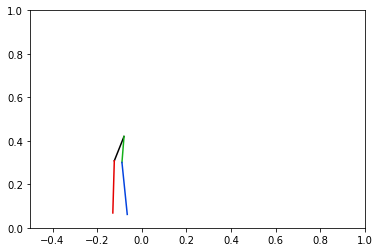

In [26]:
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from IPython.display import HTML
from matplotlib.animation import PillowWriter
%matplotlib inline

print(results.solver.status) 
print(results.solver.termination_condition) 

#m.ddq0[2,'z'].pprint()
#m.ddq0[2,'x'].pprint()


fig1, ax1 = plt.subplots(1,1) #create axes
#ax1.set_aspect('equal')

def plot_robot(i,m,ax): #update function for animation
    ax.clear()
    ax.set_xlim([-0.5,1])
    ax.set_ylim([0,1])
    
    #plot link 1
    link1_top_x = m.q0[i,'x'].value 
    link1_top_z = m.q0[i,'z'].value 
    link1_bottom_x = m.q0[i,'x'].value  + m.l1*np.sin(m.q0[i,'theta_1'].value)
    link1_bottom_z = m.q0[i,'z'].value  - m.l1*np.cos(m.q0[i,'theta_1'].value)  
    ax.plot([link1_top_x,link1_bottom_x],[link1_top_z,link1_bottom_z],color='xkcd:black')
    
    #plot link 2  
    link2_bottom_x = link1_bottom_x + m.l2*np.sin(m.q0[i,'theta_1'].value+m.q0[i,'theta_2'].value)
    link2_bottom_z = link1_bottom_z - m.l2*np.cos(m.q0[i,'theta_1'].value+m.q0[i,'theta_2'].value)
    ax.plot([link1_bottom_x,link2_bottom_x],[link1_bottom_z,link2_bottom_z],color='xkcd:red')
    
    #plot link 3
    link3_top_x = m.q0[i,'x'].value  
    link3_top_z = m.q0[i,'z'].value 
    link3_bottom_x = m.q0[i,'x'].value  + m.l3*sin(m.q0[i,'theta_3'].value)
    link3_bottom_z = m.q0[i,'z'].value  - m.l3*cos(m.q0[i,'theta_3'].value)  
    ax.plot([link3_top_x,link3_bottom_x],[link3_top_z,link3_bottom_z],color='xkcd:green')
    
    #plot link 4  
    link4_bottom_x = link3_bottom_x + m.l4*sin(m.q0[i,'theta_3'].value+m.q0[i,'theta_4'].value)
    link4_bottom_z = link3_bottom_z - m.l4*cos(m.q0[i,'theta_3'].value+m.q0[i,'theta_4'].value)
    ax.plot([link3_bottom_x,link4_bottom_x],[link3_bottom_z,link4_bottom_z],color='xkcd:blue')
       
update = lambda i: plot_robot(i,m,ax1) #lambdify update function

animate = ani.FuncAnimation(fig1,update,range(1,N+1),interval = 50,repeat=False)

animate.save('0.42_hop.gif', writer='PillowWriter', fps=10)

HTML(animate.to_jshtml())